In [77]:
import numpy as np
import pandas as pd
import os
import torch
from torch.autograd import Variable
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append("../Network-SDE-Inference/utils")
import LaGNA_flocks
import Self_func
import Interaction_func
from LaGNA_flocks import *
from Self_func import *
from Interaction_func import *

In [79]:
USE_CUDA = False

In [80]:
Timeseries = pd.read_csv('../Network-SDE-Inference/Data/Time series/flocks_timeseries_2dim_hf4.csv',encoding='utf-8',header=None)

In [81]:
Adj = pd.read_csv('../Network-SDE-Inference/Data/Topology/hf4_matrix.csv',encoding='utf-8',header=None)

In [82]:
model = 'flocks'

In [83]:
Num_nodes = Adj.shape[0]
Dimension = int(Timeseries.shape[1]/Num_nodes)

In [84]:
time = Timeseries.values
timeseries = time.reshape(( -1, Num_nodes, Dimension)) # checked, correct input data

In [85]:
delt_t = 0.01

In [86]:
timeseries_t0 = timeseries[0:-1,:,:]
timeseries_t1 = timeseries[1:,:,:]
dX = (timeseries_t1-timeseries_t0)
dXdt = (timeseries_t1-timeseries_t0)/delt_t

In [87]:
timeseries_t2 = timeseries[2:,:,:]
dVdt = (timeseries_t2-2*timeseries_t1[:-1,:,:]+timeseries[0:-2,:,:])/delt_t**2

In [88]:
import numpy as np
def get_edge_index(Adj):
    num_nodes = Adj.shape[0]
    Adj = Adj.values
    edge_index = torch.from_numpy(np.array(np.where(Adj)))
    return edge_index

In [89]:
edge_index = get_edge_index(Adj) #target to source

index = [1,0]
edge_index = edge_index[index] #source to target 
# checked, correct input edge_index data

In [90]:
#data = data.reshape((10,-1,4,6))
import numpy as np
goal_data = np.concatenate([timeseries[3:,:,:],dXdt[1:-1,:,:],dVdt[:-1,:,:]],axis=2)
#goal_data = data[1:-1,:,0:Dimension]
mapping_data = np.concatenate((timeseries[1:-2,:,:],dXdt[0:-2,:,:]),axis=2)

In [91]:
X = torch.as_tensor(np.array(mapping_data).astype('float'))
y = torch.as_tensor(np.array(goal_data).astype('float'))

In [92]:
from sklearn.model_selection import train_test_split

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2)
X_train = X_train.float()
y_train = y_train.float()
X_test = X_test.float()
y_test = y_test.float()

In [94]:
import torch
from torch import nn
from torch.functional import F
from torch.optim import Adam
from torch_geometric.nn import MetaLayer, MessagePassing

In [95]:
aggr = 'add'
hidden = 100


msg_dim = 3
n_f = mapping_data.shape[2]

In [96]:
dim = Dimension*1

In [97]:
from torch_geometric.data import Data, DataLoader

In [99]:
ogn = SDI_Difftype(model,n_f, msg_dim, dim, delt_t, hidden=hidden, edge_index=edge_index , aggr=aggr)

In [100]:
messages_over_time = []
selfDyn_over_time = []
diffusion_over_time = []

In [101]:
x=X_train[1]
y=y_train[1]
_q = Data(
    x=X_train[1],
    edge_index=edge_index,
    y=y_train[1])

In [102]:
ogn.loss(_q)

tensor(29.2184, grad_fn=<AddBackward0>)

In [103]:
batch = 64
trainloader = DataLoader(
    [Data(
        Variable(X_train[i]),
        edge_index=edge_index,
        y=Variable(y_train[i])) for i in range(len(y_train))],
    batch_size=batch,
    shuffle=True
)

testloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=edge_index,
        y=y_test[i]) for i in range(len(y_test))],
    batch_size=128,
    shuffle=True
)

/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [104]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

In [105]:
init_lr = 1e-4

opt = torch.optim.Adam(ogn.parameters(), lr=init_lr, weight_decay=1e-8)

# total_epochs = 200
total_epochs = 30

batch_per_epoch = 2000

sched = OneCycleLR(opt, max_lr=init_lr,
                   steps_per_epoch=batch_per_epoch,#len(trainloader),
                   epochs=total_epochs, final_div_factor=1e5)

In [106]:
epoch = 0
from tqdm import tqdm

In [107]:
import numpy as onp
onp.random.seed(0)
test_idxes = onp.random.randint(0, len(X_test), 1000)

#Record messages over test dataset here:
newtestloader = DataLoader(
     [Data(
         X_test[i],
         edge_index=edge_index,
         y=y_test[i]) for i in test_idxes],
     batch_size=len(X_test),
     shuffle=False
 )

In [108]:
import numpy as onp
import pandas as pd

def get_messages(ogn):

    def get_message_info(tmp):
        ogn.cpu()

        s1 = tmp.x[tmp.edge_index[0]] #source

        s2 = tmp.x[tmp.edge_index[1]] #target

        #Tmp = torch.cat([s2, s1],dim=1) # tmp --> xi,xj
        xtmp = (s1[:,0:dim]-s2[:,0:dim])
        vtmp = (s1[:,dim:dim*2]-s2[:,dim:dim*2])
        if dim == 1:
            Xtmp = torch.sqrt((s1[:,0]-s2[:,0])**2)
        if dim == 2:
            Xtmp = torch.sqrt((s1[:,0]-s2[:,0])**2+(s1[:,1]-s2[:,1])**2)
        if dim == 3:
            Xtmp = torch.sqrt((s1[:,0]-s2[:,0])**2+(s1[:,1]-s2[:,1])**2+(s1[:,2]-s2[:,2])**2)
 
        cohesion = ogn.msg_fnc_cohesion(Xtmp.reshape(-1,1))
        align = ogn.msg_fnc_align(Xtmp.reshape(-1,1))
        #repulsion = ogn.msg_fnc_repulsion(Xtmp.reshape(-1,1))
    
        all_messages = torch.cat((
            xtmp,vtmp,cohesion,align), dim=1)
        if dim == 1:
            columns = ['xij','dxij','c1','a1']
        if dim == 2:
            columns = ['xij','yij','dxij','dyij','c1','a1']
        elif dim == 3:
            columns = ['xij','yij','zij','dxij','dyij','dzij','c1','a1']

        return pd.DataFrame(
              data=all_messages.cpu().detach().numpy(),
             columns=columns
        )
        #print(all_messages.shape)
        return pd.DataFrame(all_messages)

    msg_info = []
    for i, g in enumerate(newtestloader):
        msg_info.append(get_message_info(g))

    msg_info = pd.concat(msg_info)
    
    return msg_info

In [109]:
def get_diffusion(ogn):
    def get_diffusion_info(tmp):
        ogn.cpu()
        
        tmp = tmp.x[tmp.edge_index[1]]
        if dim==1:
            self_diff_x = ogn.stochastic_x(tmp)
            self_diff_all = torch.cat((tmp,self_diff_x), dim=1)
            columns = ['xi','dxi','d1']
            
        if dim==2:
            self_diff_x = ogn.stochastic_x(tmp)
            self_diff_y = ogn.stochastic_y(tmp)
            self_diff_all = torch.cat((tmp,self_diff_x,self_diff_y), dim=1)
            columns = ['xi','yi','dxi','dyi','d1','d2']
        if dim==3:
            self_diff_x = ogn.stochastic_x(tmp)
            self_diff_y = ogn.stochastic_y(tmp)
            self_diff_z = ogn.stochastic_z(tmp)
            self_diff_all = torch.cat((tmp,self_diff_x,self_diff_y,self_diff_z), dim=1)
            columns = ['xi','yi','zi','dxi','dyi','dzi','d1','d2','d3']
            
        return pd.DataFrame(
              data=self_diff_all.cpu().detach().numpy(),
             columns=columns
        )
        return pd.DataFrame(self_diff_all)

    selfDiffusion_info = []
    for i, g in enumerate(newtestloader):
        selfDiffusion_info.append(get_diffusion_info(g))

    selfDiffusion_info = pd.concat(selfDiffusion_info)
    return selfDiffusion_info 

In [110]:
def get_selfDynamics(ogn):
    def get_selfDynamics_info(tmp):
        ogn.cpu()
        
        tmp = tmp.x[tmp.edge_index[1]]
        if dim==1:
            vtmp = torch.sqrt(tmp[:,1]**2)
            self_dyn = ogn.node_fnc_strength(vtmp.reshape(-1,1))
            self_dyn_all = torch.cat((tmp[:,1:2],self_dyn), dim=1)
            columns = ['dxi','s1']
            
        if dim==2:
            vtmp = tmp[:,2]**2+tmp[:,3]**2
            vxtmp = torch.cat((vtmp.reshape(-1,1),tmp[:,2].reshape(-1,1)),dim=1)
            vytmp = torch.cat((vtmp.reshape(-1,1),tmp[:,3].reshape(-1,1)),dim=1)
            
            self_dyn_x = ogn.node_fnc_strength_x(vxtmp)#vtmp.reshape(-1,1)
            self_dyn_y = ogn.node_fnc_strength_y(vytmp)#vtmp.reshape(-1,1)
            self_dyn_all = torch.cat((vtmp.reshape(-1,1),tmp[:,2:4],self_dyn_x, self_dyn_y), dim=1)
            columns = ['Vi','dxi','dyi','s1','s2']
        if dim==3:
            vtmp = torch.sqrt(tmp[:,3]**2+tmp[:,4]**2+tmp[:,5]**2)
            self_dyn = ogn.node_fnc_strength(vtmp.reshape(-1,1))
            self_dyn_all = torch.cat((tmp[:,3:6],self_dyn), dim=1)
            columns = ['dxi','dyi','dzi','s1']
            
        return pd.DataFrame(
              data=self_dyn_all.cpu().detach().numpy(),
             columns=columns
        )
        return pd.DataFrame(self_dyn_all)

    selfDyn_info = []
    for i, g in enumerate(newtestloader):
        selfDyn_info.append(get_selfDynamics_info(g))

    selfDyn_info = pd.concat(selfDyn_info)
    return selfDyn_info

In [111]:
recorded_models = []

In [112]:
for epoch in tqdm(range(epoch, total_epochs)):
    ogn
    total_loss = 0.0
    i = 0
    j = 0
    num_items = 0
    valid_loss = 0
    valid_num_items = 0
    while i < batch_per_epoch:
        for ginput in trainloader:
            if i >= batch_per_epoch:
                break
            opt.zero_grad()
            ginput.x = ginput.x
            ginput.y = ginput.y
            ginput.edge_index = ginput.edge_index
            ginput.batch = ginput.batch
            loss = ogn.loss(ginput)
            loss.backward()
            #(loss/int(ginput.batch[-1]+1)).backward()
            opt.step()
            sched.step()

            total_loss += loss.item()
            i += 1
            num_items += int(ginput.batch[-1]+1)
    
    ogn.eval()
    with torch.no_grad():
        while j < batch_per_epoch:
            for ginput in testloader:
                if j>= batch_per_epoch:
                    break
                ginput.x = ginput.x
                ginput.y = ginput.y
                ginput.edge_index = ginput.edge_index
                ginput.batch = ginput.batch
                loss = ogn.loss(ginput)#/int(ginput.batch[-1]+1)
                valid_loss += loss.item()
                valid_num_items += int(ginput.batch[-1]+1)
                j += 1



    cur_loss = total_loss/num_items
    cur_valid_loss = valid_loss/valid_num_items
    print(cur_loss)
    print(cur_valid_loss)
    cur_msgs = get_messages(ogn)
    cur_selfdyn = get_selfDynamics(ogn)
    cur_diff = get_diffusion(ogn)
    cur_msgs['epoch'] = epoch
    cur_msgs['loss'] = cur_loss
    messages_over_time.append(cur_msgs)
    selfDyn_over_time.append(cur_selfdyn)
    diffusion_over_time.append(cur_diff)
    
    ogn.cpu()
    from copy import deepcopy as copy
    recorded_models.append(copy(ogn.state_dict()))

  0%|                                                    | 0/50 [00:00<?, ?it/s]

8.686740062998956
7.836548408539855


  2%|▊                                        | 1/50 [01:55<1:34:28, 115.69s/it]

6.843997490219955
5.576291513616302


  4%|█▋                                       | 2/50 [03:51<1:32:22, 115.47s/it]

3.4156889919713205
0.5877894427576434


  6%|██▍                                      | 3/50 [05:47<1:30:53, 116.04s/it]

-4.360132677217912
-10.81435458136316


  8%|███▎                                     | 4/50 [07:44<1:29:15, 116.42s/it]

-21.732478884634062
-35.414987090058546


 10%|████                                     | 5/50 [09:42<1:27:42, 116.95s/it]

-56.53207142587494
-81.7892360531876


 12%|████▉                                    | 6/50 [11:43<1:26:47, 118.35s/it]

-115.45081703394536
-142.72089482465324


 14%|█████▋                                   | 7/50 [13:43<1:25:15, 118.96s/it]

-147.80755325742012
-151.82658354293912


 16%|██████▌                                  | 8/50 [15:43<1:23:28, 119.26s/it]

-150.0714277441713
-155.22630540881485


 18%|███████▍                                 | 9/50 [17:43<1:21:36, 119.44s/it]

-151.31296791617044
-152.79372426946296


 20%|████████                                | 10/50 [19:43<1:19:47, 119.69s/it]

-150.68914254394667
-157.5058588624852


 22%|████████▊                               | 11/50 [21:44<1:17:56, 119.91s/it]

-152.71651860684477
-159.61078414410215


 24%|█████████▌                              | 12/50 [23:44<1:15:56, 119.90s/it]

-152.17375165533744
-158.26449663750523


 26%|██████████▍                             | 13/50 [25:44<1:13:58, 119.96s/it]

-152.89299887074804
-158.73190034913426


 28%|███████████▏                            | 14/50 [27:43<1:11:54, 119.84s/it]

-153.249526117371
-159.13709016640482


 30%|████████████                            | 15/50 [29:41<1:09:32, 119.21s/it]

-156.75062974268695
-162.73689503519736


 32%|████████████▊                           | 16/50 [31:38<1:07:08, 118.49s/it]

-158.68867547155278
-164.72500887262535


 34%|█████████████▌                          | 17/50 [33:35<1:04:53, 118.00s/it]

-160.4447176888033
-167.07510714083332


 36%|██████████████▍                         | 18/50 [35:34<1:03:03, 118.24s/it]

-163.16943944010333
-167.72483731786295


 38%|███████████████▏                        | 19/50 [37:34<1:01:28, 118.98s/it]

-165.03388248217638
-171.08142716718177


 40%|████████████████▊                         | 20/50 [39:35<59:47, 119.57s/it]

-166.99492657172866
-165.25746014226064


 42%|█████████████████▋                        | 21/50 [41:36<58:01, 120.06s/it]

-169.59945082506164
-170.30517407924194


 44%|██████████████████▍                       | 22/50 [43:35<55:52, 119.75s/it]

-172.1965608918225
-179.73106455991166


 46%|███████████████████▎                      | 23/50 [45:35<53:48, 119.58s/it]

-175.09045900733983
-179.88316717170537


 48%|████████████████████▏                     | 24/50 [47:32<51:28, 118.77s/it]

-177.56301102572456
-184.62539812836945


 50%|█████████████████████                     | 25/50 [49:28<49:14, 118.16s/it]

-180.03742109833456
-183.45768036909877


 52%|█████████████████████▊                    | 26/50 [51:25<47:06, 117.78s/it]

-182.3988818753058
-180.32129991327943


 54%|██████████████████████▋                   | 27/50 [53:22<45:04, 117.58s/it]

-184.26262501416036
-191.132805179453


 56%|███████████████████████▌                  | 28/50 [55:19<43:00, 117.29s/it]

-186.18884274101205
-192.5683753126799


 58%|████████████████████████▎                 | 29/50 [57:16<41:00, 117.16s/it]

-188.11762705154572
-192.60700728496164


 60%|█████████████████████████▏                | 30/50 [59:13<39:01, 117.07s/it]

-189.679747170427
-189.5654720885366


 62%|████████████████████████▊               | 31/50 [1:01:09<37:02, 116.97s/it]

-191.4196518817677
-185.21578977962292


 64%|█████████████████████████▌              | 32/50 [1:03:06<35:04, 116.91s/it]

-192.75064132929566
-190.49305144693787


 66%|██████████████████████████▍             | 33/50 [1:05:03<33:07, 116.93s/it]

-194.3991567876671
-197.9567987595245


 68%|███████████████████████████▏            | 34/50 [1:07:00<31:10, 116.91s/it]

-195.40962993943876
-198.46457659593128


 70%|████████████████████████████            | 35/50 [1:08:57<29:14, 116.96s/it]

-196.92010556317285
-199.81163112680062


 72%|████████████████████████████▊           | 36/50 [1:10:54<27:16, 116.90s/it]

-198.01223008001102
-197.90049139535103


 74%|█████████████████████████████▌          | 37/50 [1:12:50<25:18, 116.82s/it]

-198.9024172527354
-196.7581908736018


 76%|██████████████████████████████▍         | 38/50 [1:14:47<23:21, 116.80s/it]

-199.80124522361922
-202.81470856007397


 78%|███████████████████████████████▏        | 39/50 [1:16:44<21:25, 116.86s/it]

-200.646837186604
-201.0033628198643


 80%|████████████████████████████████        | 40/50 [1:18:41<19:28, 116.81s/it]

-201.16519726046744
-203.39421711285948


 82%|████████████████████████████████▊       | 41/50 [1:20:38<17:31, 116.80s/it]

-201.9884338173863
-203.21035519906013


 84%|█████████████████████████████████▌      | 42/50 [1:22:34<15:34, 116.77s/it]

-202.36470570310425
-203.5615827515245


 86%|██████████████████████████████████▍     | 43/50 [1:24:31<13:37, 116.78s/it]

-202.70738503818174
-203.14179880802217


 88%|███████████████████████████████████▏    | 44/50 [1:26:28<11:40, 116.76s/it]

-203.05847145652422
-203.50831289801746


 90%|████████████████████████████████████    | 45/50 [1:28:25<09:43, 116.73s/it]

-203.343151792716
-203.84914661622133


 92%|████████████████████████████████████▊   | 46/50 [1:30:21<07:46, 116.70s/it]

-203.5546440804373
-203.63542808478212


 94%|█████████████████████████████████████▌  | 47/50 [1:32:18<05:50, 116.67s/it]

-203.78720194389024
-203.95520624604674


 96%|██████████████████████████████████████▍ | 48/50 [1:34:15<03:53, 116.76s/it]

-203.93350677354334
-204.0029827901513


 98%|███████████████████████████████████████▏| 49/50 [1:36:11<01:56, 116.75s/it]

-204.01058660645577
-204.1225156687244


100%|████████████████████████████████████████| 50/50 [1:38:09<00:00, 117.78s/it]


In [113]:
ogn.cpu()
ogn.load_state_dict(recorded_models[30])

<All keys matched successfully>

In [176]:
X = torch.as_tensor(np.array(mapping_data).astype('float'))
y = torch.as_tensor(np.array(goal_data).astype('float'))
x_Update = []
y_Update = []
z_Update = []
vx_Update = []
vy_Update = []
vz_Update = []
for i in range(0,20000):#X.shape[0]
    _q = Data(
        x=X[i].float(),
        edge_index=edge_index,
        y=y[i].float())
    x_tmp,v_tmp= ogn.sample_trajectories(_q)
    if i < X.shape[0]-2:
        X[i+2,:,0:dim] = x_tmp
        
        X[i+1,:,dim:] = v_tmp
    else:
        break
    x_Update.append(x_tmp[:,0].reshape(1,-1))
    y_Update.append(x_tmp[:,1].reshape(1,-1))
    #z_Update.append(x_tmp[:,2].reshape(1,-1))
    vx_Update.append(v_tmp[:,0].reshape(1,-1))
    vy_Update.append(v_tmp[:,1].reshape(1,-1))
    #vz_Update.append(v_tmp[:,2].reshape(1,-1))
x_i = torch.stack(x_Update, dim=0).reshape(-1,Num_nodes)
y_i = torch.stack(y_Update, dim=0).reshape(-1,Num_nodes)
#z_i = torch.stack(z_Update, dim=0).reshape(-1,Num_nodes)
vx_i = torch.stack(vx_Update, dim=0).reshape(-1,Num_nodes)
vy_i = torch.stack(vy_Update, dim=0).reshape(-1,Num_nodes)
#vz_i = torch.stack(vz_Update, dim=0).reshape(-1,Num_nodes)

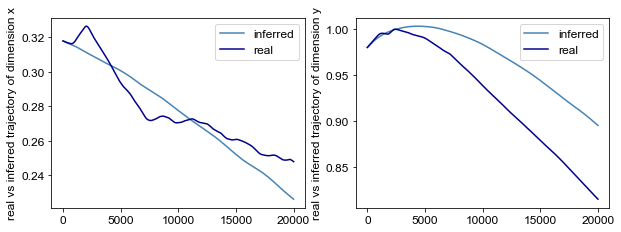

In [177]:
time1 = pd.read_csv('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/Flocks of birds/pigeonflocks_trajectories/hf1/flocks_timeseries_2dim_hf4.csv',encoding='utf-8',header=None)
plt.rcParams.update({'font.size': 12}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
#plt.rcParams['savefig.dpi'] = 300 
#plt.rcParams['figure.dpi'] = 300
Nindex =0
TIME = 20000
x_tra = x_i.detach().numpy()[0:TIME,Nindex-1]
x_real = time1.iloc[0:,Nindex*2-2]
fig = plt.figure(figsize=(10,3.5))
ax1 = fig.add_subplot(1,2,1)
t = np.arange(0,x_tra.shape[0])
ax1.plot(t,x_tra,c='steelblue',label="inferred")
ax1.plot(t, x_real[2:x_tra.shape[0]+2,],c='darkblue',label="real")
plt.ylabel('real vs inferred trajectory of dimension x')
plt.legend()

ax2 = fig.add_subplot(1,2,2)
y_tra = y_i.detach().numpy()[0:TIME,Nindex-1]
y_real = time1.iloc[0:,Nindex*2-1]
t = np.arange(0,y_tra.shape[0])
ax2.plot(t,y_tra,c='steelblue',label="inferred")
ax2.plot(t, y_real[2:y_tra.shape[0]+2,],c='darkblue',label="real")
plt.ylabel('real vs inferred trajectory of dimension y')
plt.legend()

#plt.savefig('/Users/lanag/OneDrive/Project2-StochasticDynamics/StochasticRossler/Figures/weightedRossler_intensity01_average_trajectories.png')
plt.show()
#plt.close()

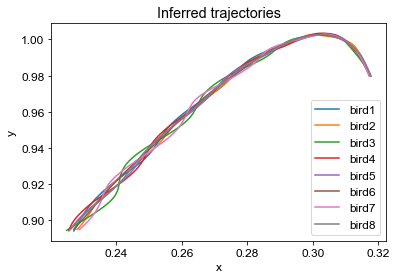

In [226]:
import matplotlib.pyplot as plt
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

r = np.linspace(0, 200, 20000)
fig, ax = plt.subplots()
x1 = x_i.detach().numpy()[0:TIME,0]
y1 = y_i.detach().numpy()[0:TIME,0]
ax.plot(x1, y1, label='bird1')
#ax.scatter(x1, y1, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)
x2 = x_i.detach().numpy()[0:TIME,1]
y2 = y_i.detach().numpy()[0:TIME,1]
ax.plot(x2, y2, label='bird2')
#ax.scatter(x2, y2, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)
x3 = x_i.detach().numpy()[0:TIME,2]
y3 = y_i.detach().numpy()[0:TIME,2]
ax.plot(x3, y3, label='bird3')
#ax.scatter(x3, y3, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)
x4 = x_i.detach().numpy()[0:TIME,3]
y4 = y_i.detach().numpy()[0:TIME,3]
ax.plot(x4, y4, label='bird4')
#ax.scatter(x4, y4, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)
x5 = x_i.detach().numpy()[0:TIME,4]
y5 = y_i.detach().numpy()[0:TIME,4]
ax.plot(x5, y5, label='bird5')
#ax.scatter(x5, y5, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)
x6 = x_i.detach().numpy()[0:TIME,5]
y6 = y_i.detach().numpy()[0:TIME,5]
ax.plot(x6, y6, label='bird6')
#ax.scatter(x6, y6, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)
x7 = x_i.detach().numpy()[0:TIME,6]
y7 = y_i.detach().numpy()[0:TIME,6]
ax.plot(x7, y7, label='bird7')
#ax.scatter(x7, y7, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)
x8 = x_i.detach().numpy()[0:TIME,7]
y8 = y_i.detach().numpy()[0:TIME,7]
ax.plot(x8, y8, label='bird8')
#ax.scatter(x8, y8, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)

# x = x_real[1:20001,]
# y = y_real[1:20001,]
# ax.scatter(x, y, c = plt.cm.YlGnBu(r/max(r)),alpha=0.5, s= 1)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Inferred trajectories')
ax.legend()
plt.savefig('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/Flocks of birds/Figures/hf4_inferred.pdf')
plt.show()

/var/folders/tx/qq1ds3m144q1b4ghn62l4kjc0000gn/T/ipykernel_31230/2751892123.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


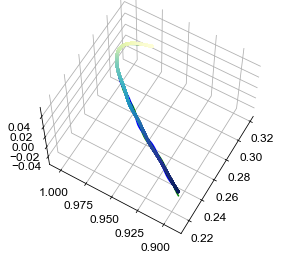

In [116]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.azim = -150
ax.dist = 9
ax.elev = 60
r = np.linspace(0, 200, 20000)


x_tra_1 = x_i.detach().numpy()[0:TIME,Nindex+1]
y_tra_1 = y_i.detach().numpy()[0:TIME,Nindex+1]
#z_tra_1 = z_i.detach().numpy()[0:TIME,Nindex+1]
x = x_tra_1#x_real[1:x_tra.shape[0]+1,]
y = y_tra_1#y_real[1:y_tra.shape[0]+1,]
#z = z_tra_1#z_real[1:z_tra.shape[0]+1,]

x_tra_2 = x_i.detach().numpy()[0:TIME,Nindex+2]
y_tra_2 = y_i.detach().numpy()[0:TIME,Nindex+2]
#z_tra_2 = z_i.detach().numpy()[0:TIME,Nindex+2]
x2 = x_tra_2#x_real[1:x_tra.shape[0]+1,]
y2 = y_tra_2 #y_real[1:y_tra.shape[0]+1,]
#z2 = z_tra_2#z_real[1:z_tra.shape[0]+1,]

x_tra_3 = x_i.detach().numpy()[0:TIME,Nindex+3]
y_tra_3 = y_i.detach().numpy()[0:TIME,Nindex+3]
#z_tra_3 = z_i.detach().numpy()[0:TIME,Nindex+3]
x3 = x_tra_3#x_real[1:x_tra.shape[0]+1,]
y3 = y_tra_3 #y_real[1:y_tra.shape[0]+1,]
#z3 = z_tra_3#z_real[1:z_tra.shape[0]+1,]


x1 = x_tra
y1 = y_tra
#z1 = z_tra

#1 colored by value of `z`
ax.plot(x, y, c = 'k') 
ax.plot(x2, y2, c = 'g') 
ax.plot(x3, y3, c = 'b') 
#2 colored by index (same in this example since z is a linspace too)

ax.scatter(x1, y1, c = plt.cm.YlGnBu(r/max(r)),alpha=0.5, s= 3)

plt.show()

In [198]:
bestMe = messages_over_time[29]

In [199]:
bestMe

,xij,yij,dxij,dyij,c1,a1,epoch,loss
0,0.000097,0.000377,-0.000097,-0.000031,0.002771,0.001040,29,-188.117627
1,-0.000990,0.000415,0.000030,-0.000035,0.002729,0.001015,29,-188.117627
2,-0.000741,0.000507,-0.000043,-0.000035,0.002740,0.001021,29,-188.117627
3,0.000391,0.000356,-0.000165,-0.000081,0.002762,0.001035,29,-188.117627
4,0.000260,0.000254,-0.000202,-0.000078,0.002773,0.001041,29,-188.117627
...,...,...,...,...,...,...,...,...
55995,0.000522,0.000067,-0.000103,0.000076,0.002763,0.001035,29,-188.117627
55996,0.000056,0.000148,0.000040,0.000067,0.002785,0.001048,29,-188.117627
55997,0.000089,-0.000064,-0.000108,0.000032,0.002788,0.001050,29,-188.117627
55998,0.000798,0.000331,-0.000091,0.000059,0.002742,0.001022,29,-188.117627


In [200]:
rij_val = np.sqrt(bestMe['xij'].values**2+bestMe['yij'].values**2)
#cohesion_true = 1.5*(1-(rij_val/2)**3)/(1+(rij_val/2)**6) # x1 (x_i) is target, x2 (x_j) is source 
align_true = np.exp(-rij_val/3)#np.sin(bestMe['x2'].values-bestMe['x1'].values)

In [201]:
maxy = np.max(bestMe['a1'].values)
miny = np.min(bestMe['a1'].values)
maxx = np.max(align_true)
minx = np.min(align_true)
align_true = (maxy-miny)*(align_true-minx)/(maxx-minx) + miny

In [202]:
(maxy-miny)/(maxx-minx)

0.11006817

In [203]:
minx

0.9988282

In [204]:
maxx-minx

0.0011715889

In [205]:
miny

0.0009249449

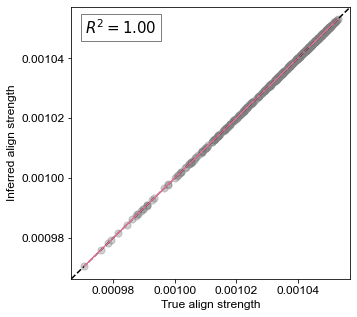

In [235]:
plt.rcParams.update({'font.size': 12}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sx = bestMe['a1'].values[0:1000]#*bestMe['dxij']*m2
sx_true = align_true[0:1000]#*bestMe['dxij']
sy = bestMe['a1'].values[0:5000]#*bestMe['dyij']*m2
sy_true = align_true[0:5000]#*bestMe['dyij']
#sz = bestMe['a1'].values#*bestMe['dzij']*m2
#sz_true = align_true#*bestMe['dzij']
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(1,1,1)
#plt.title("true align- x dimension vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax1.scatter(sx_true,sx,s=50,c ='grey', alpha=0.2)
ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--',c='k', label="1:1 line")
parameterx = np.polyfit(sx_true,sx,1)
fx = np.poly1d(parameterx)
ax1.plot(sx_true,fx(sx_true),c='palevioletred',lw=1)
corrx = np.corrcoef(sx_true,sx)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrx**2), transform=ax1.transAxes, size=15, bbox=bbox)
plt.xlabel("True align strength")
plt.ylabel("Inferred align strength")
plt.savefig('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/Flocks of birds/Figures/hf4_align.pdf')

In [250]:
coup_value = -((rij_val/2-1)**3/(1+rij_val/2)**6)+1
#coup_value = ((rij_val/0.1)**3-1)/((rij_val/0.1)**6+1)

In [251]:
maxy = np.max(bestMe['c1'].values)
miny = np.min(bestMe['c1'].values)
maxx = np.max(coup_value)
minx = np.min(coup_value)
coup_value = (maxy-miny)*(coup_value-minx)/(maxx-minx) + miny

In [252]:
coup_value

array([0.00277083, 0.00272887, 0.00273961, ..., 0.00278802, 0.00274168,
       0.00277642], dtype=float32)

In [254]:
-0.01368125*(((rij_val/2-1)**3/(1+rij_val/2)**6)-1+1.9843001)+0.0025799908

array([0.00277083, 0.00272887, 0.00273961, ..., 0.00278802, 0.00274168,
       0.00277642], dtype=float32)

In [243]:
(maxy-miny)/(maxx-minx)

0.01368125

In [253]:
minx

1.9843001

In [245]:
maxx-minx

0.015696526

In [246]:
miny

0.0025799908

Text(0, 0.5, 'inferred cohesion strength')

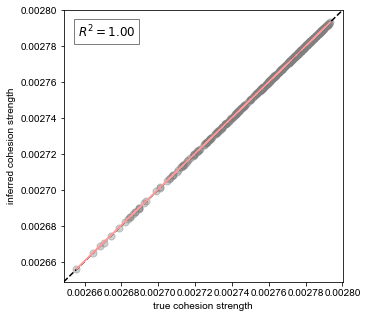

In [247]:
plt.rcParams.update({'font.size': 10}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
temp = bestMe['c1'].values[0:1000]
coup_value = coup_value[0:1000]
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1,1,1)
ax.scatter(coup_value,temp,s=50,c ='grey', alpha=0.2)
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',c='k', label="1:1 line")
parameter = np.polyfit(coup_value,temp,1)
f = np.poly1d(parameter)
ax.plot(coup_value,f(coup_value),c = '#ff9999', lw=1.5)
corr = np.corrcoef(coup_value,temp)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corr**2),transform=ax.transAxes, size=12, bbox=bbox)
#plt.title('Relation-rij-cohesion')
plt.xlabel("true cohesion strength")
plt.ylabel("inferred cohesion strength")
plt.savefig('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/Flocks of birds/Figures/hf4_cohesion.pdf')

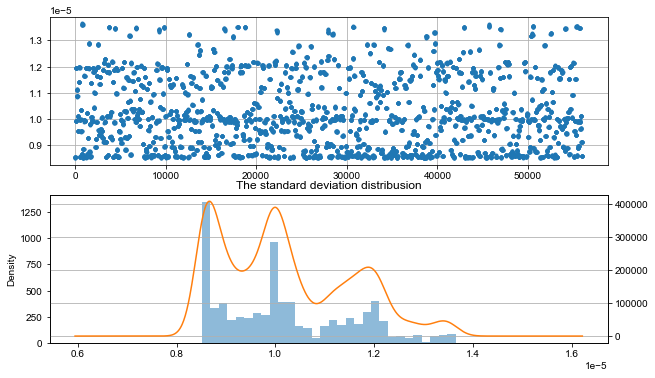

In [133]:
diffusion = diffusion_over_time[-1]
diffusion = pd.DataFrame(diffusion)
diffusion_new = pd.DataFrame.drop_duplicates(diffusion, subset=None, keep='first', inplace=False)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

s = diffusion_new['d1']/np.sqrt(0.01) # diffusion is sqrt(h)*theta(x0) 

fig = plt.figure(figsize = (10,6))
ax1 = fig.add_subplot(2,1,1)
#ax1.scatter(s.index, s.values)
ax1.plot(s.index, s.values,'.')
plt.grid()
 
ax2 = fig.add_subplot(2,1,2) 
s.hist(bins=30,alpha = 0.5,ax = ax2)
s.plot(kind = 'kde', secondary_y=True,ax = ax2)
plt.title('The standard deviation distribusion')
plt.grid()

In [215]:
best_selfDyn = selfDyn_over_time[29]
best_selfDyn = pd.DataFrame(best_selfDyn)
TimeSeries = best_selfDyn.iloc[:,0:dim].values
TimeSeries = TimeSeries.reshape(-1,Dimension)

In [216]:
best_selfDyn

,Vi,dxi,dyi,s1,s2
0,0.000001,2.240453e-04,-0.001203,-0.000059,-0.000116
1,0.000001,2.240453e-04,-0.001203,-0.000059,-0.000116
2,0.000001,2.240453e-04,-0.001203,-0.000059,-0.000116
3,0.000001,2.240453e-04,-0.001203,-0.000059,-0.000116
4,0.000001,2.240453e-04,-0.001203,-0.000059,-0.000116
...,...,...,...,...,...
55995,0.000002,-5.915492e-07,-0.001258,-0.000059,-0.000115
55996,0.000002,-5.915492e-07,-0.001258,-0.000059,-0.000115
55997,0.000002,-5.915492e-07,-0.001258,-0.000059,-0.000115
55998,0.000002,-5.915492e-07,-0.001258,-0.000059,-0.000115


In [217]:
self_true = (best_selfDyn['dxi']**2+best_selfDyn['dyi']**2)
#self_true = best_selfDyn['dxi']*best_selfDyn['Vi']
self_true_1 = np.sqrt(best_selfDyn['Vi'])*best_selfDyn['dxi']
self_true_2 = best_selfDyn['dxi']

In [218]:
maxy = np.max(best_selfDyn['s1'].values)
miny = np.min(best_selfDyn['s1'].values)
maxx = np.max(self_true)
minx = np.min(self_true)
self_true = (maxy-miny)*(self_true-minx)/(maxx-minx) + miny

In [219]:
(maxy-miny)/(maxx-minx)

1.7975674649230606

In [220]:
minx

8.477218784719298e-07

In [221]:
maxx-minx

1.6579251109760662e-06

In [222]:
miny

-5.9990212e-05

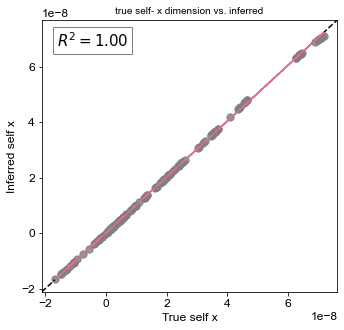

In [240]:
plt.rcParams.update({'font.size': 12}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
#self_true = 0.4*(-np.sqrt(best_selfDyn['dxi']**2+best_selfDyn['dyi']**2))
ri = np.sqrt(best_selfDyn['dxi']**2+best_selfDyn['dyi']**2)
sx = best_selfDyn['s1'].values*best_selfDyn['dxi']
sx_true = self_true*best_selfDyn['dxi']
sx = sx[0:1000]
sx_true = sx_true[0:1000]

fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(1,3,1)
plt.title("true self- x dimension vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax1.scatter(sx_true,sx,s=50,c ='grey', alpha=0.2)
ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--',c='k', label="1:1 line")
parameterx = np.polyfit(sx_true,sx,1)
fx = np.poly1d(parameterx)
ax1.plot(sx_true,fx(sx_true),c='palevioletred',lw=1.5)
corrx = np.corrcoef(sx_true,sx)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrx**2), transform=ax1.transAxes, size=15, bbox=bbox)
plt.xlabel("True self x")
plt.ylabel("Inferred self x")
plt.savefig('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/Flocks of birds/Figures/hf4_self.pdf')